Running the dual-link algorithm

In [619]:
import os
import sys
import json
import torch
import importlib
import matplotlib.pyplot as plt
# Get the current working directory
scripts_dir = os.getcwd()
# Go up one level
project_root = os.path.abspath(os.path.join(scripts_dir, '..'))
sys.path.append(project_root)

import src.dual_link
importlib.reload(src.dual_link)
from src.dual_link import dual_link_alg

In [640]:
# The setup
L = 8
PT = 100
w = [1] * L
tol_alg = 1e-2
max_iter_alg = 100
data_streams = [4] * L
d = data_streams

# The channel matrix
H = []
for i in range(L):
    l = []
    for j in range(L):
        l.append(torch.randn(8, 8, dtype=torch.cdouble))
    H.append(l)

sigma_init = []
for l in range(L):
    V = torch.rand(H[0][l].shape[1], d[l], dtype=torch.cdouble)
    sigma_init.append(V @ V.conj().T)

# Initialize sigma
ss = 0
for l in range(L):
    ss += torch.trace(sigma_init[l])
sigma_init = [sigma_init[l] * (PT/ss.real) for l in range(L)]

sigma = sigma_init

# Run the algorithm
dl = dual_link_alg(H, w, PT, tol_alg, max_iter_alg, data_streams)
R_l, sigma_l = dl.algorithm(sigma)

Compare with another implementation

In [622]:
#dual-link algorithm
def alg_dual_link(power_total: float, weight: np.ndarray, H_links: np.ndarray,
                  rate_diff: float, Sigma=None):
    """
    update: rates, sum_rate, Sigma, Sigma_hat
    """
    #------------------------------------------------
    # find basic parameters
    #------------------------------------------------
    n_links = H_links.shape[0]
    rates = np.zeros(n_links)
    Sigma_hat = np.ndarray((n_links), dtype=np.ndarray)
    #------------------------------------------------
    # If initial Sigma not given, make it identity
    #------------------------------------------------
    if Sigma is None:
        Sigma = np.ndarray((n_links), dtype=np.ndarray)
        for l_link in range(n_links):
            lt_l = H_links[l_link, l_link].shape[1]
            # power constraint may not be satisfied
            Sigma[l_link] = power_total / lt_l / n_links * np.eye(lt_l, dtype=complex)
    # print(Sigma)
    #---------------------------------------------
    # normalize the inital Sigma to fit power constraint
    #---------------------------------------------
    # else:
    #     temp_power = 0.0
    #     for l_link in range(n_links):
    #         temp_power += np.trace(Sigma[l_link])
    #     #normalize to power_total
    #     Sigma *= power_total / temp_power

    #---------------------------------------------
    # repeat until rate change is small
    sum_rate_temp = -np.inf
    # The loop break point is in the middle
    sum_rate_list = []
    while True:
    # for ii in range(2):
        # calculate reverse link Sigma_hat's
        power_normalizer = 0.0
        sum_rate = 0.0
        for l_link in range(n_links):
            # calculate forward link interference
            total_Cov_l = np.eye(H_links[l_link, l_link].shape[0], dtype=complex)
            for k_link in range(n_links):
                total_Cov_l += H_links[l_link, k_link] @ Sigma[k_link] \
                               @ H_links[l_link, k_link].T.conj()
            Omega_l = total_Cov_l - H_links[l_link, l_link] @ Sigma[l_link] \
                      @ H_links[l_link, l_link].T.conj()

            # print(Omega_l)
            # -------------------------------------------------------------------
            # calculate the rates
            _, hy = np.linalg.slogdet(total_Cov_l)
            _, hy_x = np.linalg.slogdet(Omega_l)
            rates[l_link] = (hy - hy_x).real
            # -------------------------------------------------------------------
            sum_rate += weight[l_link] * rates[l_link]

            Sigma_hat[l_link] = weight[l_link] * (np.linalg.inv(Omega_l) -
                                                  np.linalg.inv(total_Cov_l))
            power_normalizer += np.trace(Sigma_hat[l_link])
        #end
            # print(Sigma[l_link])
            # print(Omega_l)
            # print(rates[l_link]/np.log(2))
            # print('***********')
        # -------------------------------------------------------------------
        # break out of loop if rate change is small
        # print(rates/np.log(2))
        sum_rate_list.append(sum_rate/np.log(2))
        # print(sum_rate/np.log(2))
        if sum_rate/np.log(2)-sum_rate_temp/np.log(2) < rate_diff:
            break
        # --------------------------------------------------------------------
        sum_rate_temp = sum_rate
        Sigma_hat *= power_total / power_normalizer
        # --------------------------------------------------------------------
        # calculate forward link Sigma's
        # --------------------------------------------------------------------
        power_normalizer = 0.0
        for l_link in range(n_links):
            # calculate forward link interference
            total_Cov_hat_l = np.eye(H_links[l_link, l_link].shape[1], dtype=complex)
            for k_link in range(n_links):
                total_Cov_hat_l += H_links[k_link, l_link].T.conj() @ Sigma_hat[k_link] \
                                   @ H_links[k_link, l_link]
            Omega_hat_l = total_Cov_hat_l - H_links[l_link, l_link].T.conj() @ Sigma_hat[l_link] \
                          @ H_links[l_link, l_link]

            Sigma[l_link] = weight[l_link] * (np.linalg.inv(Omega_hat_l) -
                                              np.linalg.inv(total_Cov_hat_l))
            power_normalizer += np.trace(Sigma[l_link])
        #end
        Sigma *= power_total / power_normalizer
    return sum_rate_list, sum_rate/np.log(2), rates/np.log(2), Sigma, Sigma_hat

In [641]:
H1 = [[H[i][j].clone().detach().numpy().copy() for j in range(L)] for i in range(L)]
H1 = np.array(H1)

sigma1 = [sigma[i].clone().detach().numpy().copy() for i in range(L)]
sigma1 = np.array(sigma1)

sum_rate_list, _, _, _, _ = alg_dual_link(power_total=PT, weight=w, H_links=H1, rate_diff=tol_alg, Sigma=sigma1)

Text(0, 0.5, 'Sum rate')

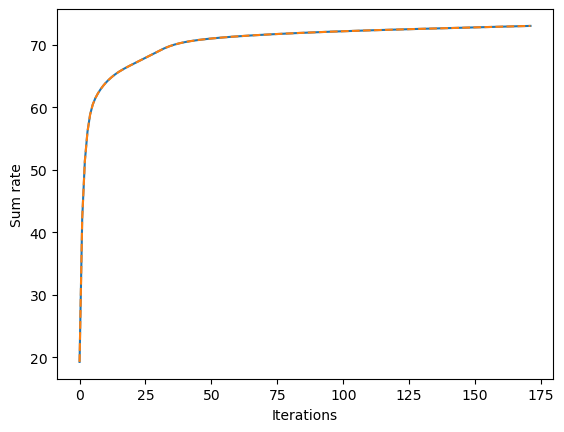

In [642]:
plt.plot(R_l)
plt.plot(sum_rate_list, linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Sum rate')